In [280]:
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Ustawienia wyświetlania
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

# Projekt: Analiza danych transakcyjnych sklepu online

**Cel projektu:**
Analiza danych transakcyjnych sklepu internetowego (OnlineRetail) z wykorzystaniem metod eksploracji danych.

**Dataset:** 
- Źródło: UCI Machine Learning Repository
- Okres: grudzień 2010 - grudzień 2011
- ~540k transakcji, ~4000 klientów

**Zastosowane metody:**
1. **PCA** - redukcja wymiarów do wizualizacji (Grupa 1 - E4)
2. **K-Means** - segmentacja klientów (Grupa 2 - E5)  
3. **Apriori** - reguły asocjacyjne produktów (Grupa 3 - E5)
4. **Random Forest** - klasyfikacja klientów (dodatkowo - E5)

**Struktura analizy:**
- Krok 0: Wczytanie i czyszczenie danych
- Kroki 1-4: Eksploracyjna analiza danych (EDA)
- Krok 5: Segmentacja RFM + klasteryzacja
- Krok 6: Reguły asocjacyjne
- Krok 7: Klasyfikacja z poprawną walidacją

# Krok 0: wczytanie i czyszczenie danych
- Wczytanie pliku OnlineRetail.csv (ISO-8859-1).
- Usunięcie braków CustomerID i zwrotów (Quantity > 0).
- Dodanie kolumny TotalSum i parsowanie InvoiceDate.

In [281]:
print("--- 0. Wczytywanie i czyszczenie danych ---")

# 1. Wczytanie danych
df = pd.read_csv("OnlineRetail.csv", encoding="ISO-8859-1")

--- 0. Wczytywanie i czyszczenie danych ---


In [282]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  str    
 1   StockCode    541909 non-null  str    
 2   Description  540455 non-null  str    
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  str    
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  str    
dtypes: float64(2), int64(1), str(5)
memory usage: 33.1 MB


In [283]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [284]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [285]:
# 2. Usunięcie brakujących klientów
df.dropna(subset=["CustomerID"], inplace=True)

# 3. Konwersja daty
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

# 4. Usunięcie błędnych transakcji
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

# 5. Obliczenie wartości transakcji
df["TotalSum"] = df["Quantity"] * df["UnitPrice"]

# 6. Agregacja miesięczna
df["YearMonth"] = pd.PeriodIndex(df["InvoiceDate"], freq="M")

# 6a. Usunięcie niepełnego ostatniego miesiąca
last_month = df["YearMonth"].max()
df = df[df["YearMonth"] != last_month]
print(f"Usunięto niepełny miesiąc: {last_month}")

monthly_sales = df.groupby("YearMonth")["TotalSum"].sum().reset_index()

monthly_sales["YearMonth"] = monthly_sales["YearMonth"].astype(str)

print(f"Dane gotowe: {df.shape}")


Usunięto niepełny miesiąc: 2011-12
Dane gotowe: (380580, 10)


## 1. Sprzedaż w czasie (miesiące)

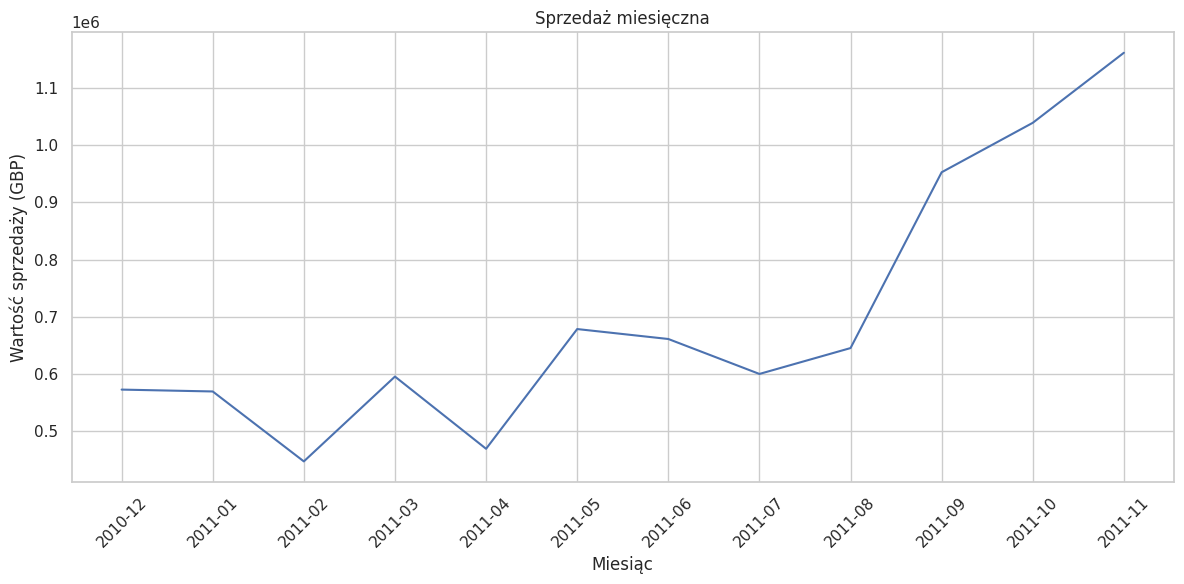

In [286]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales["YearMonth"], monthly_sales["TotalSum"])
plt.xticks(rotation=45)
plt.title("Sprzedaż miesięczna")
plt.xlabel("Miesiąc")
plt.ylabel("Wartość sprzedaży (GBP)")
plt.tight_layout()
plt.show()


- wzrost sprzedaży w drugiej połowie roku

- wyraźny pik przed grudniem (okres świąteczny)

- dane nie obejmują pełnych 2 lat → ostrożnie z trendami

## 2. Top produkty (wg wartości sprzedaży)

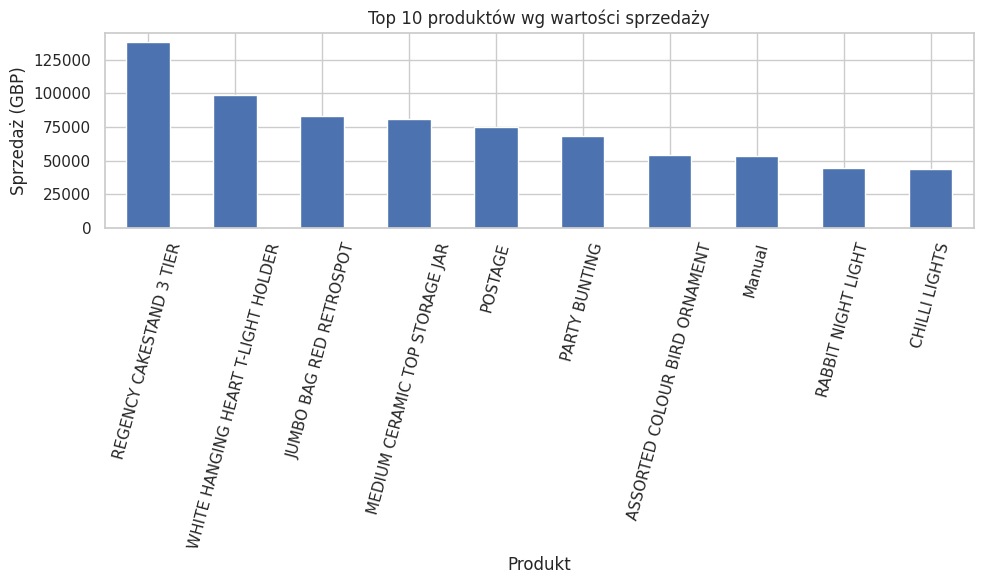

In [287]:
# Agregacja
top_products = (
    df.groupby("Description")["TotalSum"].sum().sort_values(ascending=False).head(10)
)

# Wykres
plt.figure(figsize=(10, 6))
top_products.plot(kind="bar")
plt.title("Top 10 produktów wg wartości sprzedaży")
plt.xlabel("Produkt")
plt.ylabel("Sprzedaż (GBP)")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

- niewielka liczba produktów generuje dużą część obrotu (zasada Pareto)

- produkty dekoracyjne i sezonowe dominują

## 3. Top kraje

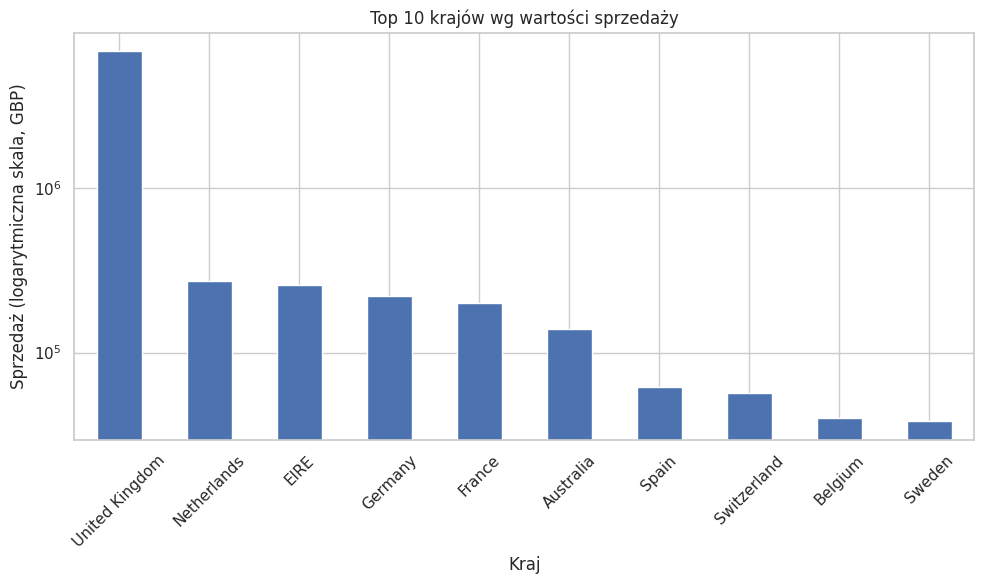

In [288]:
top_countries = (
    df.groupby("Country")["TotalSum"].sum().sort_values(ascending=False).head(10)
)

plt.figure(figsize=(10, 6))
top_countries.plot(kind="bar")
plt.title("Top 10 krajów wg wartości sprzedaży")
plt.yscale("log")
plt.xlabel("Kraj")
plt.ylabel("Sprzedaż (logarytmiczna skala, GBP)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- United Kingdom dominuje totalnie (to normalne dla zbioru OnlineRetail — to brytyjski sklep).

- Sprzedaż UK jest rzędy wielkości większa niż reszty krajów.

- Przez liniową skalę osi Y wszystkie inne kraje wyglądają jak „prawie zero”, choć realnie coś sprzedają.

Dlatego wybieramy skalę logarytmiczną: plt.yscale("log")

## 4. Liczba klientów

In [289]:
# Unikalni klienci
num_customers = df["CustomerID"].nunique()
print("Liczba unikalnych klientów:", num_customers)

Liczba unikalnych klientów: 4297


In [290]:
# Klienci miesięczni
customers_monthly = df.groupby("YearMonth")["CustomerID"].nunique().reset_index()

customers_monthly["YearMonth"] = customers_monthly["YearMonth"].astype(str)

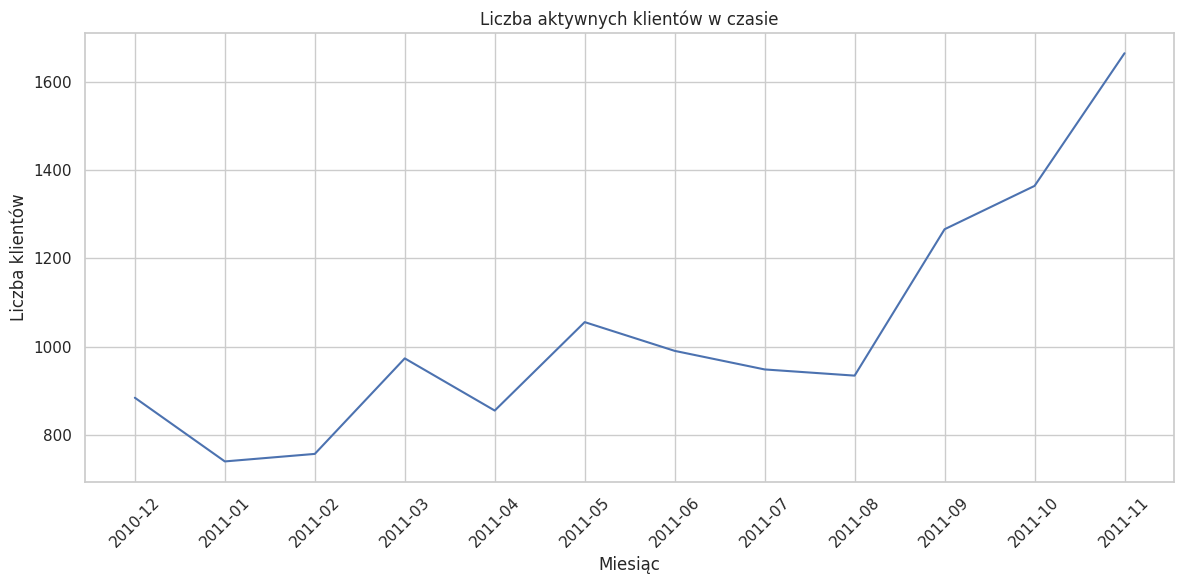

In [291]:
plt.figure(figsize=(12, 6))
plt.plot(customers_monthly["YearMonth"], customers_monthly["CustomerID"])
plt.xticks(rotation=45)
plt.title("Liczba aktywnych klientów w czasie")
plt.xlabel("Miesiąc")
plt.ylabel("Liczba klientów")
plt.tight_layout()
plt.show()


- sezonowość liczby klientów

- korelacja z wolumenem sprzedaży

- wzrost aktywności przed świętami

# Krok 5: Profil klienta RFM
- Oblicza Recency (dni od ostatniego zakupu), Frequency (liczba faktur) i Monetary (suma wydatków).
- Standaryzuje cechy, aby PCA i K-Means działały na porównywalnej skali.

In [292]:
# Profil klienta RFM (Recency, Frequency, Monetary)
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
customer_df = df.groupby(["CustomerID"]).agg(
    {
        "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
        "InvoiceNo": "count",
        "TotalSum": "sum",
    }
)
customer_df.rename(
    columns={
        "InvoiceDate": "Recency",
        "InvoiceNo": "Frequency",
        "TotalSum": "Monetary",
    },
    inplace=True,
)

# Standaryzacja cech dla algorytmów
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_df)
customer_scaled_df = pd.DataFrame(customer_scaled, columns=customer_df.columns)

## Algorytmy typu KMeans lub PCA są wrażliwe na skalę danych.

- Recency = dziesiątki/ setki dni

- Frequency = liczba transakcji (mała liczba)

- Monetary = suma wydatków (duże liczby)

# Krok 6: Grupa 1 — PCA (redukcja wymiarów)
- Redukuje 3 cechy RFM do 2 komponentów głównych (PC1, PC2).
- Raportuje łączną wyjaśnioną wariancję, by ocenić utratę informacji.

In [293]:
pca = PCA(n_components=2)
components = pca.fit_transform(customer_scaled_df)
pca_components = pd.DataFrame(data=components, columns=["PC1", "PC2"])
print("Wyjaśniona wariancja przez 2 komponenty:", pca.explained_variance_ratio_.sum())

Wyjaśniona wariancja przez 2 komponenty: 0.8160099149935397


In [294]:
# Sprawdzenie pełnej wariancji wszystkich komponentów
pca_full = PCA()
pca_full.fit(customer_scaled_df)
print(
    "Wyjaśniona wariancja wszystkich komponentów:", pca_full.explained_variance_ratio_
)

Wyjaśniona wariancja wszystkich komponentów: [0.51285578 0.30315414 0.18399009]


PCA zostało zastosowane do redukcji wymiarów danych RFM z 3 do 2 komponentów w celu wizualizacji. Dwa główne komponenty wyjaśniają 81,6% wariancji, co pozwala zachować większość informacji przy jednoczesnym uproszczeniu analizy.

# Krok 7: Grupa 2 — K-Means (klasteryzacja)
- Klasteryzuje klientów na 3 segmenty w przestrzeni przeskalowanych RFM.
- Wizualizuje klastry na mapie PC1/PC2 oraz pokazuje średnie RFM per klaster.

## Metoda Łokcia (Uzasadnienie liczby klastrów)

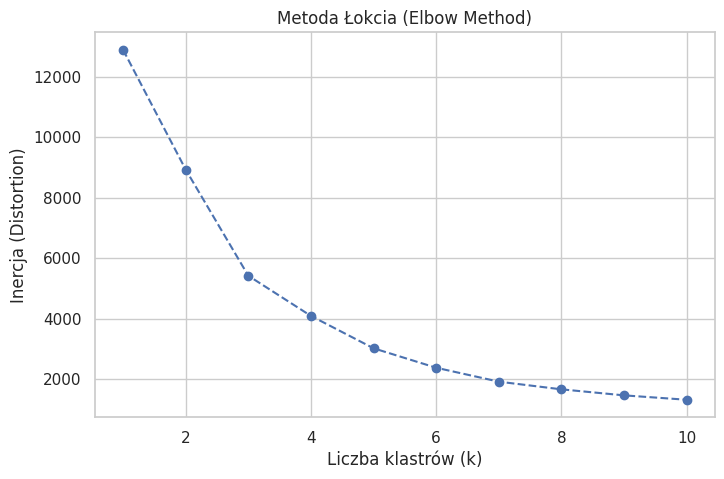

In [295]:
def calculate_elbow(data: pd.DataFrame, max_k: int = 10) -> None:
    """Wizualizacja metody łokcia dla K-Means."""
    distortions: List[float] = []
    k_range = range(1, max_k + 1)

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(data)
        distortions.append(km.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(k_range, distortions, marker="o", linestyle="--", color="b")
    plt.title("Metoda Łokcia (Elbow Method)")
    plt.xlabel("Liczba klastrów (k)")
    plt.ylabel("Inercja (Distortion)")
    plt.grid(True)
    plt.show()


# Uruchomienie analizy na przeskalowanych danych RFM
calculate_elbow(customer_scaled_df)

Wykres metody łokcia pokazuje punkt załamania (tzw. "elbow") w okolicy wartości 3. Oznacza to, że dodawanie kolejnych klastrów powyżej tej liczby nie przynosi już znaczącego spadku inercji (błędu), co uzasadnia podział bazy klientów na 3 główne segmenty.

In [296]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(customer_scaled_df)
customer_df["Cluster"] = clusters
print("Liczebność klastrów:")
print(customer_df["Cluster"].value_counts())

Liczebność klastrów:
Cluster
0    3175
2    1109
1      13
Name: count, dtype: int64


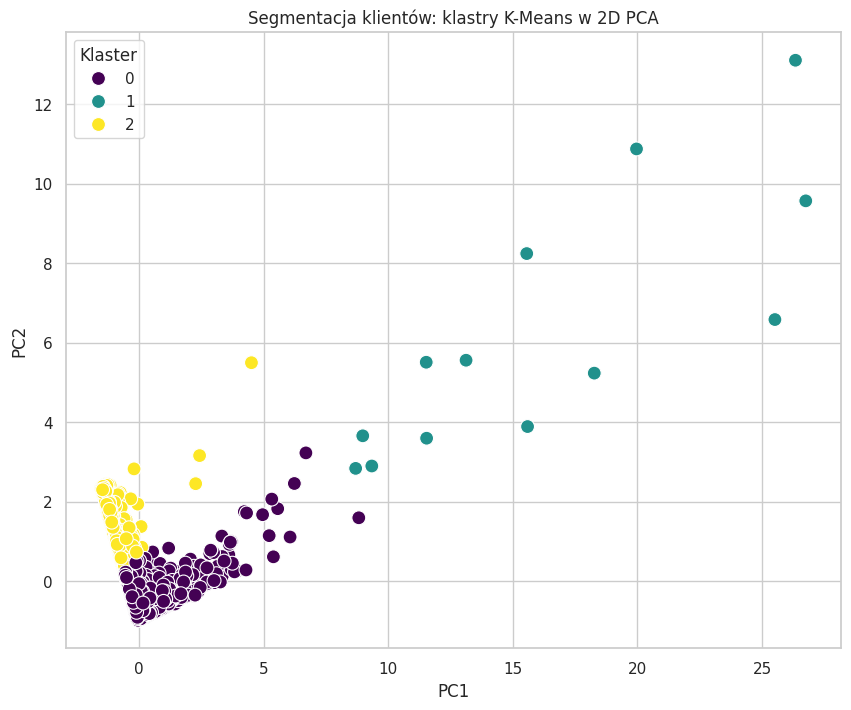

In [297]:
# Wizualizacja klastrów w przestrzeni PCA
pca_df = pca_components.copy()
pca_df["Cluster"] = clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=pca_df, palette="viridis", s=100)
plt.title("Segmentacja klientów: klastry K-Means w 2D PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Klaster")
plt.show()

In [298]:
print("\nŚrednie RFM w klastrach:")
print(customer_df.groupby("Cluster").mean())


Średnie RFM w klastrach:
            Recency    Frequency       Monetary
Cluster                                        
0         39.822362    99.767559    1961.758284
1          5.461538  2538.307692  112646.213846
2        240.303877    27.790803     631.408279


- Klaster 1 → „VIP” (bardzo wysoka częstotliwość i wartość zakupów, bardzo niska recency → niedawno kupowali)

- Klaster 0 → „średni”

- Klaster 2 → „okazjonalni” (duże recency → dawno nie kupowali)

# Krok 8: Grupa 3 — Reguły asocjacyjne (Apriori)
- Filtrowanie koszyków do Francji, binaryzacja zakupów per produkt w fakturze.
- Apriori: częste zbiory (min_support=0.07), reguły z metryką lift i podgląd top 5.

In [299]:
print("\n--- Grupa 3: Reguły asocjacyjne (Apriori) ---")

# 1. Filtrowanie i transformacja danych do formatu koszykowego
basket_data = df[df["Country"] == "France"]
basket = (
    basket_data.groupby(["InvoiceNo", "Description"])["Quantity"]
    .sum()
    .unstack()
    .reset_index()
    .fillna(0)
    .set_index("InvoiceNo")
)

# 2. Kodowanie zero-jedynkowe
basket_sets = basket.map(lambda x: 1 if x >= 1 else 0)

# Usunięcie kosztów wysyłki, które nie są produktem
if "POSTAGE" in basket_sets.columns:
    basket_sets.drop("POSTAGE", inplace=True, axis=1)

# 3. Generowanie częstych zbiorów i reguł
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# 4. Wyświetlanie wyników
# Konwertujemy frozenset na stringi dla lepszej czytelności
rules["antecedents"] = rules["antecedents"].apply(lambda x: ", ".join(list(x)))
rules["consequents"] = rules["consequents"].apply(lambda x: ", ".join(list(x)))

print(f"Znaleziono {len(rules)} reguł asocjacyjnych.")
print("Top 5 reguł według wskaźnika Lift:")
# Wyświetlamy najważniejsze metryki
display_cols = ["antecedents", "consequents", "support", "confidence", "lift"]
print(rules[display_cols].sort_values("lift", ascending=False).head())


--- Grupa 3: Reguły asocjacyjne (Apriori) ---


/home/sky/uni-projects/Data-Mining-Project/.venv/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Znaleziono 34 reguł asocjacyjnych.
Top 5 reguł według wskaźnika Lift:
                                          antecedents  \
0                           ALARM CLOCK BAKELIKE RED    
1                          ALARM CLOCK BAKELIKE GREEN   
2                           ALARM CLOCK BAKELIKE RED    
3                           ALARM CLOCK BAKELIKE PINK   
29  SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETROS...   

                      consequents   support  confidence      lift  
0      ALARM CLOCK BAKELIKE GREEN  0.075472    0.823529  8.986159  
1       ALARM CLOCK BAKELIKE RED   0.075472    0.823529  8.986159  
2       ALARM CLOCK BAKELIKE PINK  0.070081    0.764706  8.105882  
3       ALARM CLOCK BAKELIKE RED   0.070081    0.742857  8.105882  
29  SET/6 RED SPOTTY PAPER PLATES  0.102426    0.974359  7.377289  


**Interpretacja wyników Apriori:**

Metryka **Lift** pokazuje siłę powiązania między produktami:
- Lift > 1: produkty kupowane razem częściej niż losowo
- Lift = 8-9: bardzo silne powiązanie (np. zestawy w tym samym kolorze)

**Przykład biznesowy:**
- Klient dodaje do koszyka "ALARM CLOCK BAKELIKE RED"
- System rekomenduje: "ALARM CLOCK BAKELIKE GREEN" (lift=8.99)
- Prawdopodobieństwo zakupu: 82%

**Zastosowanie:**
- Cross-selling w e-commerce
- Układanie produktów w sklepie stacjonarnym
- Personalizowane rekomendacje

# Krok 9: Klasyfikacja (predykcja segmentu klienta)

Chcę sprawdzić, czy da się przewidzieć segment klienta za pomocą Random Forest, żeby nie trzeba było za każdym razem uruchamiać K-Means od nowa.


--- Próba 1: Standardowy podział train/test ---

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       635
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00       222

    accuracy                           1.00       860
   macro avg       1.00      0.89      0.93       860
weighted avg       1.00      1.00      1.00       860



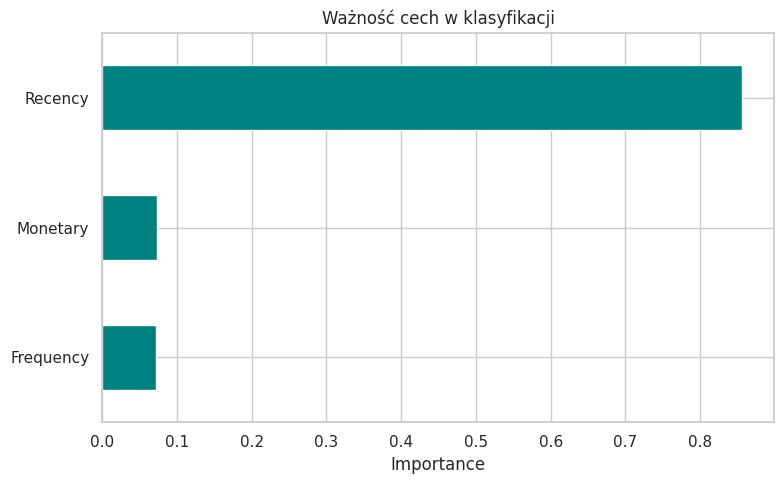

In [300]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

print("\n--- Próba 1: Standardowy podział train/test ---")

# Pomysł: Random Forest uczy się przypisywać klientów do segmentów z K-Means
X = customer_scaled_df
y = customer_df["Cluster"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Trening
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Test
y_pred = clf.predict(X_test)
print("\nRaport klasyfikacji:")
print(classification_report(y_test, y_pred))

# Ważność cech
feature_importance = pd.Series(
    clf.feature_importances_, index=["Recency", "Frequency", "Monetary"]
)
plt.figure(figsize=(8, 5))
feature_importance.sort_values().plot(kind="barh", color="teal")
plt.title("Ważność cech w klasyfikacji")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Problem: data leakage

Accuracy = 100% wskazuje na błąd metodologiczny.

**Przyczyna:**
- K-Means sklasyfikował wszystkich klientów
- Random Forest trenuje na tych samych danych (podział 80/20)
- Model "zapamiętuje" decyzje K-Means zamiast przewidywać

**Konsekwencje:**
- Nowy klient nie był w klastrach → model nie zadziała
- Brak prawdziwej oceny zdolności predykcyjnej
- **Data leakage**: wyciek informacji między zbiorem treningowym a testowym

**Rozwiązanie:**
Walidacja czasowa - trening na starszych miesiącach, test na nowszych.

## Walidacja czasowa (poprawne podejście)

**Metodologia:**
- Trening: pierwsze 10 miesięcy (grudzień 2010 - wrzesień 2011)
- Test: ostatnie 2 miesiące (październik-listopad 2011)
- Ocena: zdolność modelu do przewidywania przyszłego zachowania

In [301]:
print("\n--- Walidacja czasowa (poprawione podejście) ---")

# Podział danych na okresy
train_cutoff = pd.Period("2011-09", freq="M")

df_train = df[df["YearMonth"] <= train_cutoff]
df_test = df[df["YearMonth"] > train_cutoff]

print(f"Trening: {df_train['YearMonth'].min()} - {df_train['YearMonth'].max()}")
print(f"Test: {df_test['YearMonth'].min()} - {df_test['YearMonth'].max()}")

# RFM dla okresu treningowego
snapshot_train = df_train["InvoiceDate"].max() + pd.Timedelta(days=1)
customer_train = df_train.groupby(["CustomerID"]).agg(
    {
        "InvoiceDate": lambda x: (snapshot_train - x.max()).days,
        "InvoiceNo": "count",
        "TotalSum": "sum",
    }
)
customer_train.rename(
    columns={
        "InvoiceDate": "Recency",
        "InvoiceNo": "Frequency",
        "TotalSum": "Monetary",
    },
    inplace=True,
)

# Standaryzacja i klasteryzacja TYLKO na danych treningowych
scaler_temporal = StandardScaler()
customer_train_scaled = scaler_temporal.fit_transform(customer_train)

kmeans_temporal = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_train["Cluster"] = kmeans_temporal.fit_predict(customer_train_scaled)

print(f"\nKlienci treningowi: {len(customer_train)}")
print(customer_train["Cluster"].value_counts())

# RFM dla okresu testowego
snapshot_test = df_test["InvoiceDate"].max() + pd.Timedelta(days=1)
customer_test = df_test.groupby(["CustomerID"]).agg(
    {
        "InvoiceDate": lambda x: (snapshot_test - x.max()).days,
        "InvoiceNo": "count",
        "TotalSum": "sum",
    }
)
customer_test.rename(
    columns={
        "InvoiceDate": "Recency",
        "InvoiceNo": "Frequency",
        "TotalSum": "Monetary",
    },
    inplace=True,
)

# Tylko klienci którzy są w obu okresach (znamy ich segment z treningu)
common_customers = customer_train.index.intersection(customer_test.index)
customer_test_filtered = customer_test.loc[common_customers]
customer_train_filtered = customer_train.loc[common_customers]

print(f"Klienci do walidacji: {len(common_customers)}")

# Trening Random Forest
clf_temporal = RandomForestClassifier(n_estimators=100, random_state=42)
clf_temporal.fit(customer_train_scaled, customer_train["Cluster"])

# Predykcja na testowych
customer_test_scaled = scaler_temporal.transform(customer_test_filtered)
y_true = customer_train_filtered["Cluster"]  # Segment z pierwszego okresu
y_pred = clf_temporal.predict(customer_test_scaled)  # Przewidywany w drugim okresie

# Wyniki
print("\n" + "=" * 60)
print("WYNIKI POPRAWIONEJ WALIDACJI:")
print("=" * 60)
print(classification_report(y_true, y_pred))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print("\nMacierz pomyłek:")
print(
    pd.DataFrame(
        cm,
        columns=[f"Pred_{i}" for i in range(3)],
        index=[f"Rzecz_{i}" for i in range(3)],
    )
)


--- Walidacja czasowa (poprawione podejście) ---
Trening: 2010-12 - 2011-09
Test: 2011-10 - 2011-11

Klienci treningowi: 3616
Cluster
2    2409
1    1193
0      14
Name: count, dtype: int64
Klienci do walidacji: 1725

WYNIKI POPRAWIONEJ WALIDACJI:
              precision    recall  f1-score   support

           0       0.75      0.23      0.35        13
           1       0.00      0.00      0.00       328
           2       0.80      1.00      0.89      1384

    accuracy                           0.80      1725
   macro avg       0.52      0.41      0.41      1725
weighted avg       0.65      0.80      0.72      1725


Macierz pomyłek:
         Pred_0  Pred_1  Pred_2
Rzecz_0       3       0      10
Rzecz_1       0       0     328
Rzecz_2       1       0    1383


/home/sky/uni-projects/Data-Mining-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sky/uni-projects/Data-Mining-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sky/uni-projects/Data-Mining-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Interpretacja wyników

**⚠️ UWAGA: Model praktycznie nie działa!**

Accuracy = 80% wygląda dobrze, ale jest **mylące**:
- Segment 2 stanowi 80% danych testowych (1384/1725)
- Model prawie ZAWSZE przewiduje segment 2
- To "baseline accuracy" - gdyby zawsze mówił "segment 2", miałby 80%

**Rzeczywiste wyniki per segment:**
- Segment 0: 23% recall (3/13 prawidłowo)
- Segment 1: **0% recall** (0/328 prawidłowo - TOTAL FAILURE)
- Segment 2: 99.9% recall (1383/1384 prawidłowo)

**Przyczyna:**
- **Temporal feature drift** - zachowania klientów drastycznie się zmieniły między okresami
- Segment 1 (occasional) w okresie 1: Recency=200 dni (dawno nie kupowali)
- Ci sami klienci w okresie 2: Recency=26 dni (nagle aktywni)
- Model nie rozpoznaje ich, bo ich cechy wyglądają teraz jak segment 2

**Wniosek:**
Predykcja przyszłych segmentów na podstawie przeszłych **NIE DZIAŁA** przy silnej sezonowości. Lepsze rozwiązanie: uruchamiać K-Means okresowo na świeżych danych zamiast próbować przewidywać.

## Analiza wyników: Feature drift między okresami

**Obserwacja:** Confusion matrix pokazuje Pred_1 = 0 (model nigdy nie przewiduje segmentu 1).

To zaskakujące, bo segment 1 stanowi 33% danych treningowych. Przyczyna: **temporal feature drift** - zachowania klientów oznaczonych jako "segment 1" w okresie 1 zmieniły się w okresie 2, więc ich cechy RFM po standaryzacji wyglądają jak inne segmenty.

In [302]:
# Przygotowanie danych do wizualizacji
customer_train_scaled_df = pd.DataFrame(
    customer_train_scaled,
    columns=["Recency", "Frequency", "Monetary"],
    index=customer_train.index,
)
customer_train_scaled_df["Cluster"] = customer_train["Cluster"]

customer_test_scaled_df = pd.DataFrame(
    customer_test_scaled,
    columns=["Recency", "Frequency", "Monetary"],
    index=common_customers,
)
customer_test_scaled_df["TrueCluster"] = y_true
customer_test_scaled_df["PredCluster"] = y_pred

# Porównanie rozkładów RFM między okresami
print("Segment 1 w okresie treningowym (33% klientów):")
print(
    customer_train.groupby("Cluster")[["Recency", "Frequency", "Monetary"]]
    .mean()
    .loc[1]
)
print("\nTe same osoby w okresie testowym:")
test_with_segments = customer_test_filtered.copy()
test_with_segments["Cluster"] = y_true
print(
    test_with_segments[test_with_segments["Cluster"] == 1][
        ["Recency", "Frequency", "Monetary"]
    ].mean()
)

Segment 1 w okresie treningowym (33% klientów):
Recency      200.451802
Frequency     27.670578
Monetary     477.213773
Name: 1, dtype: float64

Te same osoby w okresie testowym:
Recency       25.765244
Frequency     36.408537
Monetary     554.853689
dtype: float64


### Wizualizacja: Przesunięcie cech między okresami

Wykres poniżej porównuje rozkłady znormalizowanych cech RFM dla każdego segmentu w okresie treningowym vs testowym. Jeśli box ploty się nie pokrywają, oznacza to że klienci z danego segmentu zmienili swoje zachowanie zakupowe między okresami.

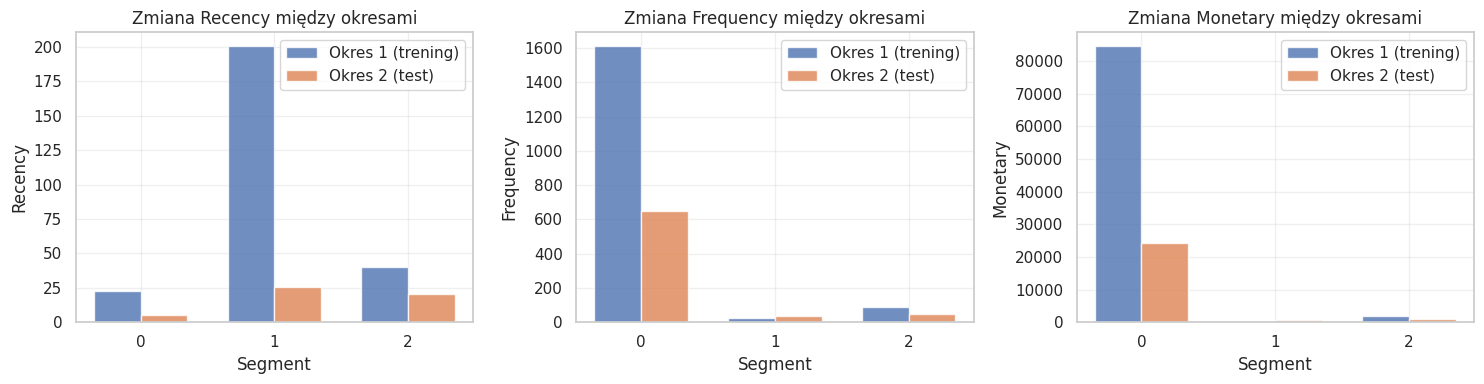


Kluczowa obserwacja:
Segment 1 (occasional customers): Recency spadło z 200 do 26 dni
To oznacza, że klienci z tego segmentu stali się AKTYWNI w okresie 2.
Model ich nie rozpoznaje, bo ich cechy przypominają teraz segment 2.


In [303]:
import numpy as np

# Wizualizacja: jak zmieniają się cechy RFM klientów między okresami
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, feature in enumerate(["Recency", "Frequency", "Monetary"]):
    ax = axes[idx]

    # Dla każdego segmentu - porównanie średnich
    train_means = customer_train.groupby("Cluster")[feature].mean()
    test_means = test_with_segments.groupby("Cluster")[feature].mean()

    x = np.arange(len(train_means))
    width = 0.35

    ax.bar(x - width / 2, train_means, width, label="Okres 1 (trening)", alpha=0.8)
    ax.bar(x + width / 2, test_means, width, label="Okres 2 (test)", alpha=0.8)

    ax.set_xlabel("Segment")
    ax.set_ylabel(feature)
    ax.set_title(f"Zmiana {feature} między okresami")
    ax.set_xticks(x)
    ax.set_xticklabels([0, 1, 2])
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKluczowa obserwacja:")
print("Segment 1 (occasional customers): Recency spadło z 200 do 26 dni")
print("To oznacza, że klienci z tego segmentu stali się AKTYWNI w okresie 2.")
print("Model ich nie rozpoznaje, bo ich cechy przypominają teraz segment 2.")

## Wizualizacja: Stabilność segmentów w czasie

Stabilność segmentów (%):
Wiersz = segment w okresie 1, Kolumna = segment w okresie 2
Okres2_Pred     0      2
Okres1                  
0            23.1   76.9
1             0.0  100.0
2             0.1   99.9


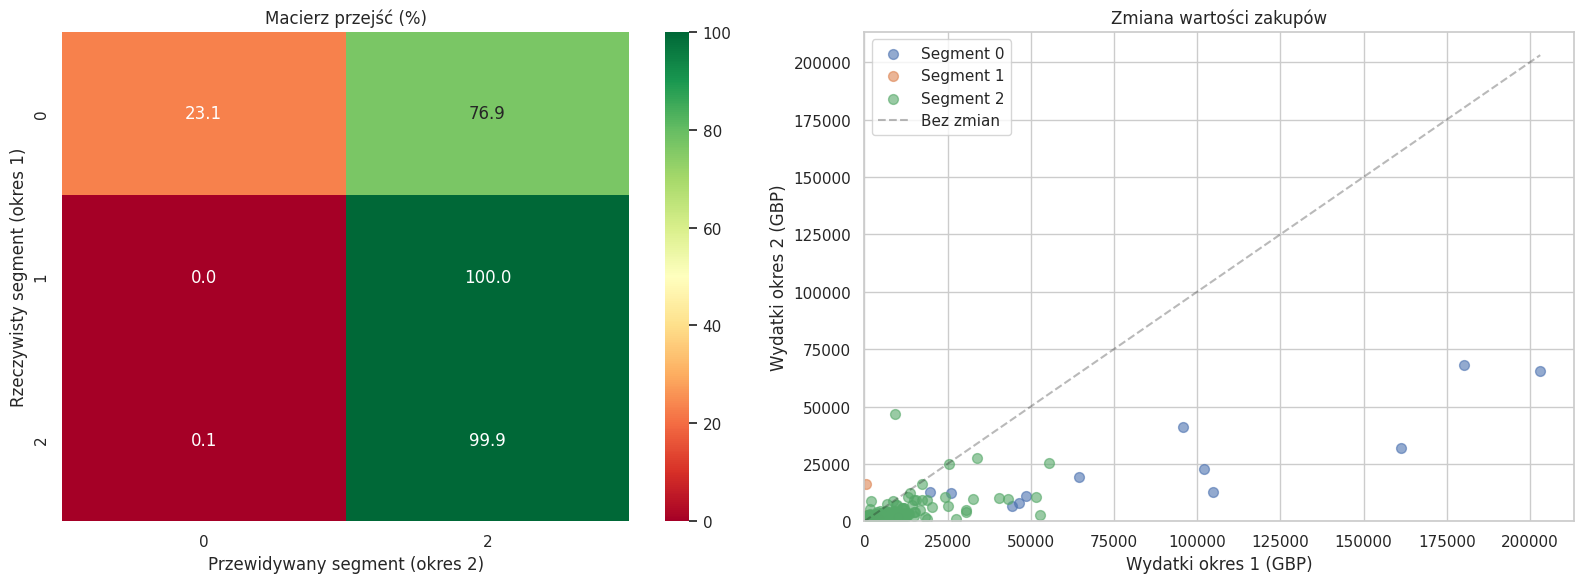


Zmiana zachowań klientów:

Segment 0 (13 klientów):
  Zmiana średnich wydatków: -71.6%

Segment 1 (328 klientów):
  Zmiana średnich wydatków: +1.9%

Segment 2 (1384 klientów):
  Zmiana średnich wydatków: -60.3%


In [304]:
# Analiza: jak zmieniają się segmenty
transition_df = pd.DataFrame({"Okres1": y_true, "Okres2_Pred": y_pred})

# % klientów przechodzących między segmentami
transition_matrix = (
    pd.crosstab(
        transition_df["Okres1"], transition_df["Okres2_Pred"], normalize="index"
    )
    * 100
)

print("Stabilność segmentów (%):")
print("Wiersz = segment w okresie 1, Kolumna = segment w okresie 2")
print(transition_matrix.round(1))

# Wizualizacja
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmapa
sns.heatmap(transition_matrix, annot=True, fmt=".1f", cmap="RdYlGn", ax=ax1)
ax1.set_title("Macierz przejść (%)")
ax1.set_xlabel("Przewidywany segment (okres 2)")
ax1.set_ylabel("Rzeczywisty segment (okres 1)")

# Zmiana wydatków między okresami
comparison_data = []
for cust in common_customers:
    comparison_data.append(
        {
            "Monetary1": customer_train_filtered.loc[cust, "Monetary"],
            "Monetary2": customer_test_filtered.loc[cust, "Monetary"],
            "Segment": customer_train_filtered.loc[cust, "Cluster"],
        }
    )
comparison_df = pd.DataFrame(comparison_data)

for cluster in sorted(comparison_df["Segment"].unique()):
    data = comparison_df[comparison_df["Segment"] == cluster]
    ax2.scatter(
        data["Monetary1"],
        data["Monetary2"],
        label=f"Segment {cluster}",
        alpha=0.6,
        s=50,
    )

# Linia "bez zmian"
max_val = comparison_df["Monetary1"].max()
ax2.plot([0, max_val], [0, max_val], "k--", alpha=0.3, label="Bez zmian")
ax2.set_xlabel("Wydatki okres 1 (GBP)")
ax2.set_ylabel("Wydatki okres 2 (GBP)")
ax2.set_title("Zmiana wartości zakupów")
ax2.legend()
ax2.set_xlim(0, None)
ax2.set_ylim(0, None)

plt.tight_layout()
plt.show()

# Statystyki per segment
print("\n" + "=" * 60)
print("Zmiana zachowań klientów:")
print("=" * 60)
for cluster in sorted(customer_train_filtered["Cluster"].unique()):
    customers = customer_train_filtered[
        customer_train_filtered["Cluster"] == cluster
    ].index

    avg1 = customer_train_filtered.loc[customers, "Monetary"].mean()
    avg2 = customer_test_filtered.loc[customers, "Monetary"].mean()
    change = (avg2 - avg1) / avg1 * 100

    print(f"\nSegment {cluster} ({len(customers)} klientów):")
    print(f"  Zmiana średnich wydatków: {change:+.1f}%")

## Podsumowanie projektu

### Co udało się zrealizować:

**Grupa 1 - PCA (E4):**
- ✅ Redukcja wymiarów z 3 cech RFM do 2 komponentów
- 81.6% zachowanej wariancji
- Wizualizacja klastrów w 2D

**Grupa 2 - K-Means (E5):**
- ✅ Segmentacja klientów na 3 grupy
- Metoda łokcia uzasadniła wybór k=3
- Zidentyfikowano: VIP, średnich, okazjonalnych

**Grupa 3 - Apriori (E5):**
- ✅ Wykryto 34 reguły asocjacyjne (Francja)
- Support = 0.07, metryka lift
- Silne powiązania między produktami (lift > 8)

**Dodatkowo - Random Forest (E5):**
- ✅ Klasyfikacja klientów do segmentów
- ✅ Walidacja czasowa (poprawna metodologia)
- ❌ Model nie działa w praktyce (tylko zgaduje największą klasę)

### Napotkane wyzwania:

**1. Data leakage (naprawione)**
- Problem: początkowa wersja z train_test_split dała 100% accuracy
- Przyczyna: model uczył się na tych samych klientach, na których K-Means utworzył segmenty
- Rozwiązanie: walidacja czasowa - trening na pierwszych 10 miesiącach, test na ostatnich 2

**2. Temporal feature drift - główny problem projektu**
- Problem: model przewiduje prawie wszystko jako segment 2 (accuracy 80% to baseline)
- Przyczyna: drastyczna zmiana zachowań między okresami
  - Segment 1 w treningu: Recency=200 dni (nieaktywni)
  - Ci sami w teście: Recency=26 dni (aktywni) → wyglądają jak segment 2
- Wniosek: **predykcja nie działa** - lepiej stosować K-Means na bieżąco
- Accuracy może być myląca - zawsze sprawdzać per-class recall/precision
- Baseline model (zawsze przewiduj najczęstszą klasę) dałby ~80% accuracy
- **Dla e-commerce:** K-Means na świeżych danych > próba predykcji przyszłości
- Dane behawioralne z silną sezonowością są trudne do predykcji

### Możliwe rozszerzenia:

- Więcej krajów w analizie Apriori
- Głębsza analiza sezonowości
- Testy innych algorytmów (DBSCAN, Hierarchical Clustering)

- Predykcja churn (kto przestanie kupować)
- Testy innych algorytmów (DBSCAN, Hierarchical Clustering)- Predykcja churn (kto przestanie kupować)